## TODO:

1. Data: 
    - create script to combine all congresses
    - create a party and chamber lists for addtional support
    - create congress number list

2. Train/Val/Test split:
    - Put into a separate module
    - Add an option to select a party or chapter
    - Split train/val/test by congress to avoid time bias
    - Play with hyperparameters:
        - word_count
        - random_splits: allocate more to training?
        - increase balance ratio?

3. EDA:
    - Targets by party: should we run gender/ethnicity on Ds only?

4. Vectorization:
    - Tune hyper parameters:
        - ngram_range: 1, 3
        - change vocabulary size
    - Add outputs:
        - stop words
        - lowest scoring words
        - top 5/bottom 5 by congress

5. Ngram model:
    - Tune hyper parameters:
        - use GridSearch?
        - activation function
        - learning rate
        - batch size
        - layers
        - units
        - dropout rate
        - any other regularization (there is significant overfit)
    - Run model:
        - for each congress
        - add one congress at a time
           - hypothesis: is accuracy improving due to more data or more diversity?
        - run only for Ds?
    - Outputs:
        - how to output predicted probablity?
    - Model validation:
        - build a separate function so it can be used with different models:
            - input: predicted probability; actual labels; data (val or test?)
        - chart distribution of the predicted probability 
        - bin predicted probabilities into:
            - 0:0.4, 0.4:0.6, 0.6:1?
            - accuracy in each bin
            - crosstab them with various demos (party, chamber, age, year)
            - get 1,2,3-grams for each bin
        - output examples of speeches with scores close to 1 and close to 0 that are mispredicted vs predicted correctly
        - Accuracy/loss by congress
        - Accuracy/loss as congresses added
            - save them and plot them

### Long term:

1. classificaiton models:
    - ngram vanilla NN
    - CNN
    - some other models
    - does it help to combine the results ensemble? if they make different mistakes, it should.
2. Create a topics model:
    - on raw data before classification
    - on groups based on predicted probability bings:
       - can we explain classification by topics that they bring up?
       - or is it just based on language used? here we would check 1,2,3-ngrams
3. Age:
    - aging congress: how does it affect topics that people bring up?
4. Speaker-level analysis:
    - cluster speakers (k-means?) by their average predicted scores in classification models?
        - for example, a white male that is closer to women by the way they use speech? are they liberals?

Inspiration for code: https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random

import numpy as np
import pandas as pd

from importlib import reload

import nltk, re, pprint
from nltk import word_tokenize

In [70]:
from w266_common import utils, vocabulary
from helpers import explore_data

## Load the data

In [5]:
pwd

'/tf/notebooks/final-project/Classification'

In [4]:
!head -2 /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [15]:
!cat /tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt | wc -l

283399


In [13]:
filepath = '/tf/notebooks/final-project/data/sample/hein-daily/speeches_097.txt'
with open(filepath, 'rb') as f:
    raw = f.read().decode(errors='replace')

In [14]:
type(raw), len(raw)

(str, 249718612)

In [9]:
raw.find('\n')

16

In [8]:
raw[:16]

'speech_id|speech'

In [16]:
raw = raw.split('\n')[1:]

In [12]:
len(raw)

249718612

In [22]:
raw[:2]

['970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for this body we pray

In [17]:
speech_ids, speeches = [], []
for speech in raw:
    speech = speech.split('|')
    # skipping empty rows
    if speech:
        speech_ids.append(speech[0])
        # some speeches have pipes in them
        speeches.append(' '.join(speech[1:]))

In [18]:
len(speech_ids), len(speeches)

(283399, 283399)

In [60]:
speech_ids[0]

'970000001'

## Create target labels

In [40]:
ls /tf/notebooks/final-project/data/QA

README.md                ethicity_aapia.txt        gs_connect.py@
__pycache__/             ethicity_black.txt        hein_daily_qa.sh*
cnt_speaker_id.sh*       ethicity_hispanic.txt     hein_daily_qa.txt
cnt_speaker_id.txt       full_descr.txt            nltk.ipynb
collecting_demo.ipynb    full_descr.zip            speakermap_qa.ipynb
congresspeople_age.txt   full_speakermap.py*       speakermap_qa.py*
congresspeople_demo.txt  full_speakermap.txt       speakermap_qa.txt
congresspeople_id.txt    full_speakermap_demo.txt  speech_descr_qa.ipynb


In [19]:
descr = {}
with open('/tf/notebooks/final-project/data/QA/full_descr.txt') as f:
    for line in f:
        line = line.strip().split('|')
        if line[0] == 'speech_id':
            keys = line[1:]
        else:
            descr[line[0]] = {k:v for k,v in zip(keys, line[1:])}

In [20]:
descr['970000005']

{'Age': '63.0',
 'Age_lt_med': '0.0',
 'Chamber': 'S',
 'Congress': '97',
 'Ethnicity': 'W',
 'Female': '0.0',
 'Full Name': 'PERCY, CHARLES',
 'NonWhite': '0.0',
 'Party': 'R',
 'State': 'IL',
 'char_count': '201',
 'date': '19810105',
 'match': 'exact',
 'speaker': 'Mr. PERCY',
 'speakerid': '97105301.0',
 'word_count': '34'}

In [53]:
descr97 = []
for s in descr:
    if s[:2] == '97':
        descr97.append(s)
len(descr97)

220819

In [55]:
descr97.sort()

In [56]:
descr97[0], descr97[-1]

('970000005', '970283398')

In [61]:
# percent of speeches that matched speaker ids
len(descr97)/len(speech_ids)

0.7791805899103385

In [21]:
gender, ethnicity, age = [], [], []
for i in speech_ids:
    gender.append(int(float(descr.get(i, {}).get('Female', '-1'))))
    ethnicity.append(int(float(descr.get(i, {}).get('NonWhite', '-1'))))
    age.append(int(float(descr.get(i, {}).get('Age_lt_med', '-1'))))

In [22]:
len(gender), len(ethnicity), len(age)

(283399, 283399, 283399)

In [23]:
def get_counts(lst):
    """
    Checks the distribution of target variables
    """
    unique, counts = np.unique(lst[0], return_counts=True)
    M = np.concatenate((unique.astype(int), counts.astype(int))).reshape((2,3)).T
    print(lst[1])
    utils.pretty_print_matrix(M, cols=['Category', 'Count'], dtype=int)

for i in [(gender, "gender"), (ethnicity, "ethnicity"), (age, "age")]:
    get_counts(i)

gender


,Category,Count
0,-1,62580
1,0,216368
2,1,4451


ethnicity


,Category,Count
0,-1,62580
1,0,211468
2,1,9351


age


,Category,Count
0,-1,62580
1,0,143811
2,1,77008


### Data QA

In [24]:
def random_speech(data, ids, target, value):
    """
    Prints a random speech for a specific target value
    
    Args:
        data: list of speeches
        ids: list of speech ids
        target: list of 0,1 
        value: int, 0 or 1
    """
    r = np.random.choice(np.array(ids)[np.array(target)==value])
    print("Speaker information")
    for i in descr[r]:
        print(i, descr[r][i])
    print()
    print(data[ids.index(r)])

In [25]:
random_speech(speeches, speech_ids, gender, 1)

Speaker information
speaker Mrs. KASSEBAUM
Ethnicity W
Chamber S
State KS
match exact
Party R
speakerid 97109311.0
Age 50.0
Age_lt_med 1.0
date 19810604
char_count 2485
word_count 390
Full Name KASSEBAUM, NANCY
Female 1.0
Congress 97
NonWhite 0.0

Mr. President. there can be little question that Government spending has made a major contribution to the economic problems we are facing today. In recognition of this. most Americans have supported a broadbased program to reduce the growth of the Federal budget. While many laudable Federal programs may be affected by these budget cuts. it has been heartening to note that American citizens are willing to bear their share of the burden now in anticipation of a future recovery. It is clear that Members of Congress and the executive branch should not expect the rest of the country to cut back when they exempt themselves from sacrifice. As a demonstration of this belief. the Senate has supported the Presidents decision to recommend no pay raise f

In [28]:
random_speech(speeches, speech_ids, ethnicity, 1)

Speaker information
speaker Mrs. COLLINS of Illinois
Ethnicity B
Chamber H
State IL
match fuzzy
Party D
speakerid 97111080.0
Age 51.0
Age_lt_med 0.0
date 19810205
char_count 3511
word_count 574
Full Name COLLINS, CARDISS
Female 1.0
Congress 97
NonWhite 1.0

Mr. Speaker. it is with immense pleasure and pride that I rise to pay tribute to the outstanding and sensitive leader of Loyola Universijy of Chicago and a constituent. Rev. Raymond C. Baumhart. On February 7. 1981. the alumni of Loyola University will honor the leadership and administration of a man who for 10 years served his university and surrounding Chicago community with Insight and excellence excelled by none. Reverend Baumhart. a distinguished man in his own right. a very talented and gifted writer. Is equally at home in theology and philosophy as he is in the business world. Father Baumhart has written extensively on business ethics and educational administration. He wrote the book.. "An Honest Profit: What Businessmen Say 

In [30]:
random_speech(speeches, speech_ids, age, 1)

Speaker information
speaker Mr. BONKER
Ethnicity W
Chamber H
State WA
match fuzzy
Party D
speakerid 97107640.0
Age 45.0
Age_lt_med 1.0
date 19810804
char_count 1572
word_count 239
Full Name BONKER, DON
Female 0.0
Congress 97
NonWhite 0.0

Mr. Speaker. with todays House passage of the conferE 4005 ence report on the tax cut. President Reagan now has had 100 percent of his economic program approved by the Congress. The President has accomplished this radical turnaround In American economic policy in Just 6 short months. Although much of the impact of the deep cuts to social. health. and educational programs will be felt almost immediately In the months ahead. the most profoundly Important repercussions of the Presidents program will not be apparent for a number of years. Recently. an article in one of the leading newspapers of the Pacific Northwest. the Seattle PostIntelligencer. offered a glimpse of what these longterm repercussions might be. The vision is a sobering one. and I commend 

## Split into train, validate, test

In [51]:
def split_train_val_test(data, ids, target, balance, splits, word_count=30):
    """
    Splits speeches into train, validation and test samples
    
    Args:
        data: list of speeches
        ids: list of speech ids
        target: list of target values (0,1,-1)
        balance: desired ratio of 0s to 1s
        splits: list of floats for [train, validation, test] splits
    
    Kwards:
        word_count: min number of words in the speech
    
    Returns:
        tuple of lists: train speeches, speech ids and target, 
                        validation speeches, speech ids and target, 
                        test speeches, speech ids and target
    """
    
    # initialize lists to hold speeches
    ones, zeroes = [], []
    ones_ids, zeroes_ids = [], []
    
    for i in range(len(target)):
        # -1 indicated non-matched speeches. They are dropped
        # select only speeches that have at least min
        # desired length
        if (target[i] != -1) and (int(descr[ids[i]]['word_count']) > word_count):
            if target[i] == 1:
                ones.append(data[i])
                ones_ids.append(ids[i])
            elif target[i] == 0:
                zeroes.append(data[i])
                zeroes_ids.append(data[i])
    
    # get lengths of train, validation and test lists
    train_ones_len = int(len(ones)*splits[0])
    val_ones_len = int(len(ones)*splits[1])
    test_ones_len = len(ones) - train_ones_len - val_ones_len
    
    if int(len(ones)*balance) < len(zeroes):
        train_zeroes_len = int(train_ones_len*balance)
        val_zeroes_len = int(val_ones_len*balance)
        test_zeroes_len = int(test_ones_len*balance)
    else:
        train_zeroes_len = int(len(zeroes)*splits[0])
        val_zeroes_len = int(len(zeroes)*splits[1])
        test_zeroes_len = len(zeroes) - train_zeroes_len - test_zeroes_len
    
    # create randomly shuffled indices
    random.seed(100)    
    ones_shuffled = np.random.permutation(np.arange(len(ones)))
    zeroes_shuffled = np.random.permutation(np.arange(len(zeroes)))
    
    # subset lists of speeches based on shuffled indices
    train_ones = [ones[i] for i in ones_shuffled[:train_ones_len]]
    val_ones = [ones[i] for i in ones_shuffled[train_ones_len:-test_ones_len]]
    test_ones = [ones[i] for i in ones_shuffled[-test_ones_len:]]

    train_ones_ids = [ones_ids[i] for i in ones_shuffled[:train_ones_len]]
    val_ones_ids = [ones_ids[i] for i in ones_shuffled[train_ones_len:-test_ones_len]]
    test_ones_ids = [ones_ids[i] for i in ones_shuffled[-test_ones_len:]]

    train_zeroes = [zeroes[i] for i in zeroes_shuffled[:train_zeroes_len]]
    val_zeroes = [zeroes[i] for i in zeroes_shuffled[train_zeroes_len:train_zeroes_len+val_zeroes_len]]
    test_zeroes = [zeroes[i] for i in zeroes_shuffled[-test_zeroes_len:]]

    train_zeroes_ids = [zeroes_ids[i] for i in zeroes_shuffled[:train_zeroes_len]]
    val_zeroes_ids = [zeroes_ids[i] for i in zeroes_shuffled[train_zeroes_len:train_zeroes_len+val_zeroes_len]]
    test_zeroes_ids = [zeroes_ids[i] for i in zeroes_shuffled[-test_zeroes_len:]]

    # combine lists
    train = train_ones + train_zeroes
    val = val_ones + val_zeroes
    test = test_ones + test_zeroes

    train_ids = train_ones_ids + train_zeroes_ids
    val_ids = val_ones_ids + val_zeroes_ids
    test_ids = test_ones_ids + test_zeroes_ids

    # create target lists
    train_target = [1]*len(train_ones) + [0]*len(train_zeroes)
    val_target = [1]*len(val_ones) + [0]*len(val_zeroes)
    test_target = [1]*len(test_ones) + [0]*len(test_zeroes)

    print("Training split: {} ones and {} zeroes".format(train_ones_len, train_zeroes_len))
    print("Training speech list size: {}".format(len(train)))
    print("Training target list size: {}".format(len(train_target)))

    print("Validation split: {} ones and {} zeroes".format(val_ones_len, val_zeroes_len))
    print("Validation speech list size: {}".format(len(val)))
    print("Validation target list size: {}".format(len(val_target)))    
    
    print("Test split: {} ones and {} zeroes".format(test_ones_len, test_zeroes_len))
    print("Test speech list size: {}".format(len(test)))
    print("Test target list size: {}".format(len(test_target)))

    return train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target

In [52]:
random_splits = [0.6, 0.2, 0.2]
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = split_train_val_test(speeches, speech_ids, gender, 1, random_splits)

Training split: 1622 ones and 1622 zeroes
Training speech list size: 3244
Training target list size: 3244
Validation split: 540 ones and 540 zeroes
Validation speech list size: 1080
Validation target list size: 1080
Test split: 542 ones and 542 zeroes
Test speech list size: 1084
Test target list size: 1084


In [53]:
sum(train_target), sum(val_target), sum(test_target)

(1622, 540, 542)

In [58]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

1747

In [59]:
random_speech(train, train_ids, train_target, 1)

Speaker information
speaker Mrs. SCHROEDER
Ethnicity W
Chamber H
State CO
match exact
Party D
speakerid 97111540.0
Age 42.0
Age_lt_med 1.0
date 19820527
char_count 940
word_count 152
Full Name SCHROEDER, PATRICIA
Female 1.0
Congress 97
NonWhite 0.0

Mr. Chairman. I move to strike the last word. Mr. Chairman. I use this time and and would like to address a question to the distinguished chairman of the Budget Committee. Section 307 of the Latta substitute says. "It is the sense of Congress that reductions in Federal employment should be accomplished by attrition only." As chairwoman of the Subcominttee on Civil Service. I know that involuntary methods of reducing the cost of the workforce. such as through reductions in force. more commonly known as RIFs. and furloughs are tremendously costly. both in dollars and in employee productivity. Mr. Chairman. I agree with section 307 of the Latta substitute and think this administrations war against Federal employees gives the lie to its profess

In [60]:
random_speech(val, val_ids, val_target, 1)

Speaker information
speaker Mrs. BYRON
Ethnicity W
Chamber H
State MD
match fuzzy
Party D
speakerid 97108830.0
Age 50.0
Age_lt_med 1.0
date 19820811
char_count 5295
word_count 839
Full Name BYRON, BEVERLY
Female 1.0
Congress 97
NonWhite 0.0

Mr. Speaker. I rise today to alert my colleagues in the House to the operations of the organization responsible for coordinating international exports. and to the need to change the orientation of this important group. The organization to which I refer is the Coordinating Committee for Multilateral Export Controls. This group. known as COCOM. was organized in 1949 and began operation in early 1950. By 1953. COCOM attained the membership that has survived to this day. being the NATO nations less Iceland and including Japan. The broad purpose of COCOM is to coordinate the restrictions on the sale and export of materials and technology to the Communist bloc. COCOM operates by formulating lists of goods and technologies that the member countries agree 

In [61]:
random_speech(test, test_ids, test_target, 1)

Speaker information
speaker Mrs. COLLIN
Ethnicity B
Chamber H
State IL
match exact
Party D
speakerid 97111080.0
Age 51.0
Age_lt_med 0.0
date 19811214
char_count 277
word_count 49
Full Name COLLINS, CARDISS
Female 1.0
Congress 97
NonWhite 1.0

% of Illinois. Mr. Chairman. I rise in support of H.R. 4700. the Standby Petroleum Emergency Authority Act of 1981. I support this legislation not so much for what it contains in the form of specific authority but rather as an affirmation of the committees concern for the fate


## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [92]:
reload(explore_data)

<module 'helpers.explore_data' from '/tf/notebooks/final-project/Classification/helpers/explore_data.py'>

In [62]:
explore_data.get_num_words_per_sample(train)

208.0

In [63]:
explore_data.get_num_words_per_sample(val)

213.5

In [64]:
explore_data.get_num_words_per_sample(test)

216.0

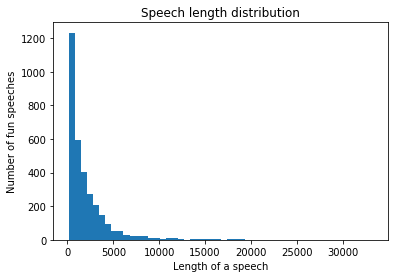

In [76]:
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

['the', 'of', 'to', 'and', 'in', 'that', 'is', 'for', 'this', 'we', 'it', 'on', 'be', 'have', 'are', 'not', 'as', 'by', 'with', 'will', 'has', 'our', 'mr', 'would', 'from', 'which', 'was', 'an', 'at', 'they', 'my', 'their', 'or', 'but', 'been', 'all', 'who', 'he', 'his', 'president', 'these', 'bill', 'if', 'do', 'there', 'amendment', 'more', 'people', 'one', 'can']


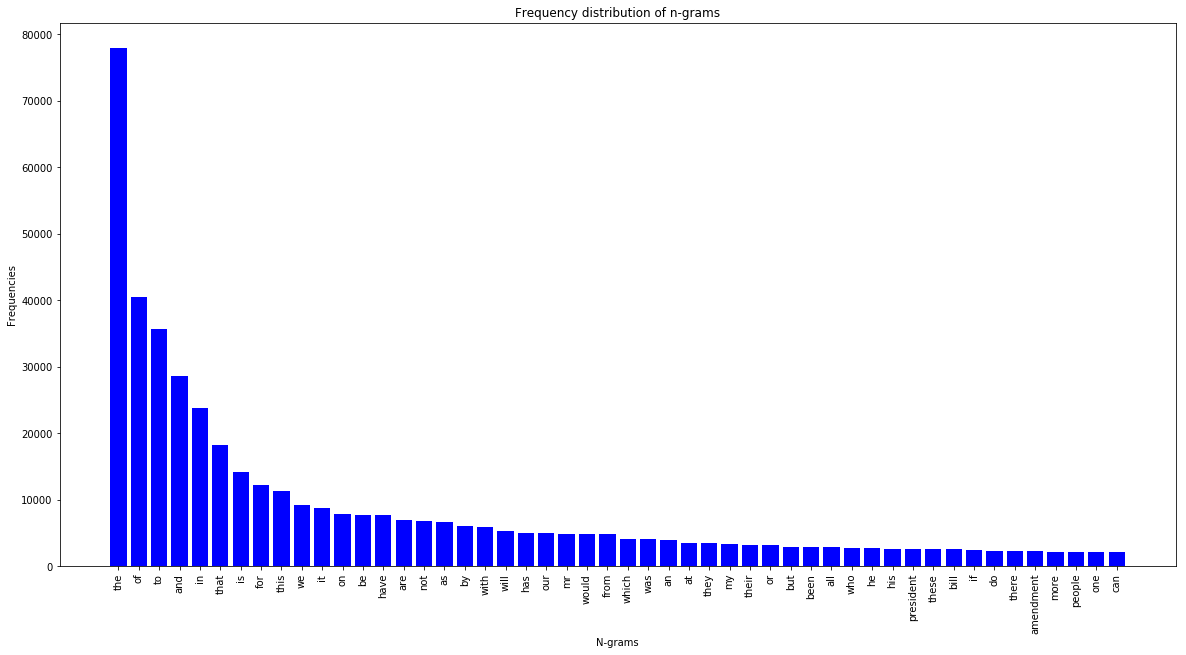

In [88]:
explore_data.plot_frequency_distribution_of_ngrams(train, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'that the', 'for the', 'and the', 'on the', 'by the', 'mr speaker', 'to be', 'with the', 'of this', 'we have', 'we are', 'mr president', 'that we', 'will be', 'in this', 'has been', 'from the', 'united states', 'the gentleman', 'the united', 'have been', 'is the', 'of our', 'at the', 'would be', 'that is', 'the house', 'is not', 'the senate', 'do not', 'mr chairman', 'there is', 'my colleagues', 'the federal', 'the bill', 'one of', 'the committee', 'as the', 'this is', 'like to', 'this bill', 'going to', 'want to', 'the american', 'the president', 'would like']


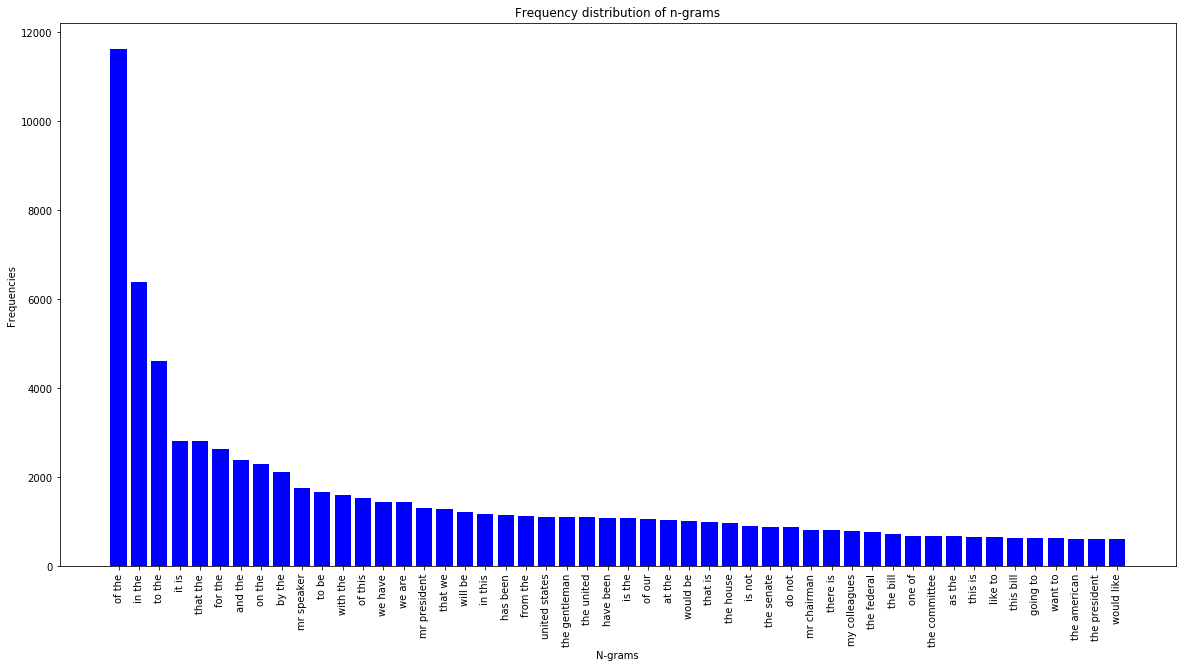

In [89]:
explore_data.plot_frequency_distribution_of_ngrams(train, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'would like to', 'the gentleman from', 'one of the', 'the senator from', 'the soviet union', 'the department of', 'the federal government', 'of the united', 'percent of the', 'chairman of the', 'in support of', 'members of the', 'the american people', 'as well as', 'of the house', 'in order to', 'my colleagues to', 'there is no', 'the fact that', 'are going to', 'the people of', 'part of the', 'some of the', 'in the united', 'it is not', 'ask unanimous consent', 'thank the gentleman', 'in the record', 'of the senate', 'the committee on', 'be able to', 'that it is', 'in this country', 'support of the', 'member of the', 'of the bill', 'urge my colleagues', 'that we have', 'that we are', 'think it is', 'in the house', 'unanimous consent that', 'we do not', 'of my colleagues', 'it is the', 'the gentleman for', 'of the american', 'rise in support', 'of the committee']


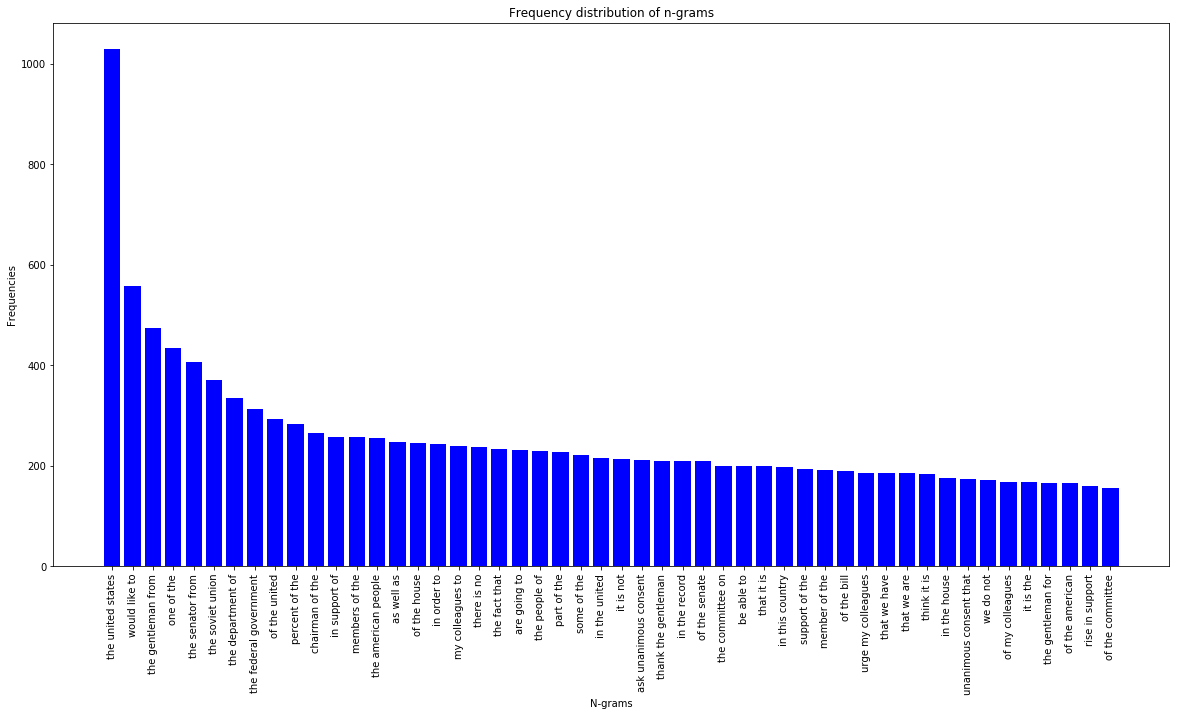

In [90]:
explore_data.plot_frequency_distribution_of_ngrams(train, ngram_range=(3,3))

## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [125]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

In [134]:
import tensorflow as tf

### Pre-processing

In [95]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

In [185]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    """
    Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of ngrams.

    Arguments:
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    Returns:
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
            'max_df': MAX_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)
    print("Total vocabulary size: {}".format(len(vectorizer.vocabulary_)))
    
    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype(dtype=np.float32)
    x_val = selector.transform(x_val).astype(dtype=np.float32)
    
    top_words = np.array(vectorizer.get_feature_names())[np.argsort(selector.scores_)[::-1]][:20]
    top_scores = selector.scores_[np.argsort(selector.scores_)[::-1]][:20]
    print("\nTop 20 words by differentiating score:")
    for i in range(len(top_words)):
        print(top_words[i], "\t", round(top_scores[i], 1))
    
    return x_train, x_val

In [186]:
train_vec, val_vec = ngram_vectorize(train, train_target, val)

/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Total vocabulary size: 107259

Top 20 words by differentiating score:
mr president 	 327.8
president 	 208.4
senator 	 177.9
the senator 	 141.0
the senate 	 111.5
senate 	 108.6
senator from 	 106.0
speaker 	 84.4
mr speaker 	 82.6
rise in 	 74.7
women 	 73.5
rise 	 61.0
senators 	 59.6
distinguished 	 59.5
the distinguished 	 58.5
support of 	 47.9
unanimous 	 46.7
unanimous consent 	 46.5
her 	 45.2
consent 	 43.6


In [108]:
len(train), len(val)

(3244, 1080)

In [107]:
train_vec.shape, val_vec.shape

((3244, 20000), (1080, 20000))

### Model: Multi-Layer Perceptron (Vanilla NN)

In [126]:
def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """
    Creates an instance of a multi-layer perceptron model.

    Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    Returns
        An MLP model instance.
    """
    op_units, op_activation = 1, 'sigmoid'
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    
    return model

In [189]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """
    Trains n-gram model on the given dataset.

    Arguments:
        data: tuples of vectorized training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    Returns:
        tuple with accuracy and loss on validation data for the last interation
    """
    # Get the data.
    (x_train, train_labels), (x_val, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = 2

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
#     model.save('C97_mlp_model.h5')
    
    return history['val_acc'][-1], history['val_loss'][-1]

In [190]:
train_ngram_model(((train_vec, train_target), (val_vec, val_target)))

Train on 3244 samples, validate on 1080 samples
Epoch 1/1000
3244/3244 - 1s - loss: 0.6746 - acc: 0.7367 - val_loss: 0.6577 - val_acc: 0.7120
Epoch 2/1000
3244/3244 - 1s - loss: 0.5990 - acc: 0.8570 - val_loss: 0.6142 - val_acc: 0.7204
Epoch 3/1000
3244/3244 - 1s - loss: 0.5100 - acc: 0.8915 - val_loss: 0.5753 - val_acc: 0.7296
Epoch 4/1000
3244/3244 - 1s - loss: 0.4281 - acc: 0.9103 - val_loss: 0.5464 - val_acc: 0.7426
Epoch 5/1000
3244/3244 - 1s - loss: 0.3572 - acc: 0.9266 - val_loss: 0.5281 - val_acc: 0.7481
Epoch 6/1000
3244/3244 - 1s - loss: 0.2963 - acc: 0.9473 - val_loss: 0.5156 - val_acc: 0.7509
Epoch 7/1000
3244/3244 - 1s - loss: 0.2526 - acc: 0.9578 - val_loss: 0.5088 - val_acc: 0.7500
Epoch 8/1000
3244/3244 - 1s - loss: 0.2154 - acc: 0.9630 - val_loss: 0.5067 - val_acc: 0.7528
Epoch 9/1000
3244/3244 - 0s - loss: 0.1838 - acc: 0.9698 - val_loss: 0.5057 - val_acc: 0.7519
Epoch 10/1000
3244/3244 - 0s - loss: 0.1586 - acc: 0.9738 - val_loss: 0.5052 - val_acc: 0.7519
Epoch 11/10

(0.7462963, 0.5084469492788668)